In [16]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
pd.set_option('display.max_columns', None)


#Graficos
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

#Metricas, Pipeline
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline

#Modelos
from sklearn import tree
from sklearn import linear_model
from sklearn import ensemble
from sklearn import naive_bayes

# Abrindo o banco de dados / Limpando dados duplicados

In [2]:
df_stats = pd.read_csv('../New_csv/df_info_statsplayers')
df_medals = pd.read_csv('../New_csv/df_info_medalhas')
df_medals = df_medals.drop(columns='Unnamed: 0')
df_stats = df_stats.drop(columns='Unnamed: 0')
df_medals = df_medals.drop_duplicates()

- Juntando os dois dataframes com o parâmetro "how='outer'" o dataframe resultante terá dados preenchido com NaN
- Vou completar esses dados com 0, pois se tivermos dados vazio em jogos ou medalhas que dizer que o player não possui valor nesse campos, não é devido a falta de informação

In [3]:
df = pd.merge(df_stats, df_medals, on=['idPlayer','Data_Ref'], how='outer')
df = df.fillna(0)

Construindo uma função que recebe duas datas e cria uma lista como todas as datas entre data_inicial e data_final

In [4]:
def listar_dias(data_inicial, data_final):
    # Converter as strings de data em objetos datetime
    data_inicial = datetime.strptime(data_inicial, '%Y-%m-%d')
    data_final = datetime.strptime(data_final, '%Y-%m-%d')

    # Gerar a lista de dias entre as datas
    dias = []
    delta = timedelta(days=1)     
    while data_inicial <= data_final:
        dias.append(data_inicial.strftime('%Y-%m-%d'))
        data_inicial += delta

    return dias

data_inicial = '2021-10-14'
data_final = '2022-01-15'         #data_final = '2022-01-15'
dias = listar_dias(data_inicial,data_final)

# Construção da variável alvo

- Objetivo: Descobrir qual a probabilidade de um player que não é assinante se tornar assinante.

- Para isso, vou filtrar os dados para que tenha somente informação dos players que não tem assinatura ativa

In [5]:
df_ML = df[df['AssinaturaAtiva'] == 0.0]
df_ML['Alvo'] = 0

C:\Users\paulo\AppData\Local\Temp\ipykernel_11784\874572345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML['Alvo'] = 0


- Minha variável alvo é definida como ['alvo'] = 1 se o player tem uma assinatura que foi criada até 15 dias depois da Data_Ref

In [6]:
for dia_ref in dias:
    df_players_medals = pd.read_csv('../Original_csv/tb_players_medalha.csv')
    df_players_medals = df_players_medals[df_players_medals['dtCreatedAt'] < df_players_medals['dtExpiration']]
    df_players_medals['dtCreatedAt'] = pd.to_datetime(df_players_medals['dtCreatedAt'])
    df_players_medals = df_players_medals[df_players_medals['dtCreatedAt'] > dia_ref]
    df_players_medals = df_players_medals[df_players_medals['dtCreatedAt'] < pd.to_datetime(dia_ref) + pd.Timedelta(days=15)]
    df_players_medals['Alvo'] = 1
    df_alvo = df_players_medals[['idPlayer', 'Alvo']].drop_duplicates()
    df_alvo['Data_Ref'] = dia_ref

    df_ML = df_ML.set_index(['idPlayer', 'Data_Ref'])
    df_alvo = df_alvo.set_index(['idPlayer', 'Data_Ref'])
    df_ML.update(df_alvo)
    df_ML = df_ML.reset_index()

df_ML = df_ML.drop_duplicates(subset=['idPlayer', 'Data_Ref'])

Limpando alguns dados que me deram problemas

In [7]:
df_ML['qtRecencia'] = df_ML['qtRecencia'].str.replace(' days', '')
df_ML = df_ML.fillna(0)
df_ML.replace([np.inf, -np.inf], 1.10, inplace=True)   # KDA tive uma divisão por zero

# Modelos de Machine Learning

1. Definindo quais são as features é o alvo
2. Devidindo a base de dados em base de treino e de teste 

In [8]:
features = df_ML.columns[2:-2]
features = features.to_list()
target = 'Alvo'

X = df_ML[features]
y = df_ML[target]

X_train, X_test, y_train, y_test = model_selection.train_test_split(df_ML[features],df_ML[target], test_size= 0.2, random_state=42, stratify=df_ML[target]) 

Treinamento do modelo: Tree

- Aqui eu coloco o grid dentro do pipeline, então meu fluxo de trabalho é:

1. Os dados passam por todas as modificações que eles precisam até estarem prontos para serem treinados
2. Os dados, agora pronto para serem treinados, passam pelo grid em que são treinados com diferentes parâmetros e é feito a comparação para eleger a melhor combinação

Desse modo eu não preciso processar os dados todas as vezes em que ele passar pelo grid com um parâmetro diferente

In [ ]:
# Definir o modelo e o pipeline

rf_clf = ensemble.RandomForestClassifier()

ada_clf = ensemble.AdaBoostClassifier()

dt_clf = tree.DecisionTreeClassifier()

rl_clf = linear_model.LogisticRegressionCV()

# Definir os parâmetros para o GridSearchCV
params = {
    }

# Criar o objeto GridSearchCV
grid = model_selection.GridSearchCV(model, param_grid=params, n_jobs=-1, scoring='roc_auc')


meu_pipeline_rf = pipeline.Pipeline([
    ('model', rf_clf)
])

meu_pipeline_ada = pipeline.Pipeline([
    ('model', ada_clf)
])

meu_pipeline_dt = pipeline.Pipeline([
    ('model', dt_clf)
])

meu_pipeline_rl = pipeline.Pipeline([
    ('model', rf_clf)
])



# Ajustar o GridSearchCV com os dados de treinamento
meu_pipeline.fit(X_train, y_train)

# Previsões usando o grid ajustado
y_train_predict = meu_pipeline.predict(X_train)
y_train_proba = meu_pipeline.predict_proba(X_train)

y_test_predict = meu_pipeline.predict(X_test)
y_test_proba = meu_pipeline.predict_proba(X_test)

Resultados_grid = pd.DataFrame(grid.cv_results_)  #Caso queria ver quais parâmetros foram selecionados 


In [ ]:
#Back codigo

# Definir o modelo e o pipeline

rf_clf = ensemble.RandomForestClassifier()

ada_clf = ensemble.AdaBoostClassifier()

dt_clf = tree.DecisionTreeClassifier()

rl_clf = linear_model.LogisticRegressionCV()

# Definir os parâmetros para o GridSearchCV
params = {
    }

# Criar o objeto GridSearchCV
grid = model_selection.GridSearchCV(model, param_grid=params, n_jobs=-1, scoring='roc_auc')


meu_pipeline_rf = pipeline.Pipeline([
    ('model', rf_clf)
])

meu_pipeline_ada = pipeline.Pipeline([
    ('model', ada_clf)
])

meu_pipeline_dt = pipeline.Pipeline([
    ('model', dt_clf)
])

meu_pipeline_rl = pipeline.Pipeline([
    ('model', rf_clf)
])



# Ajustar o GridSearchCV com os dados de treinamento
meu_pipeline.fit(X_train, y_train)

# Previsões usando o grid ajustado
y_train_predict = meu_pipeline.predict(X_train)
y_train_proba = meu_pipeline.predict_proba(X_train)

y_test_predict = meu_pipeline.predict(X_test)
y_test_proba = meu_pipeline.predict_proba(X_test)

Resultados_grid = pd.DataFrame(grid.cv_results_)  #Caso queria ver quais parâmetros foram selecionados 


Quero descobrir quais são as variáveis mais relevantes para o meu modelo 

In [10]:
f_importance = meu_pipeline[-1].best_estimator_.feature_importances_
df_importance_var_randomFlorest = pd.DataFrame(f_importance, index=features, columns=['importance']).sort_values(by='importance', ascending=False)
df_importance_var_randomFlorest.head(15)

,importance
qtRecencia,0.050206
vlLevelAVG,0.025836
qtMedalhaDist,0.020842
qtShotsAVG,0.020637
HsHate,0.020430
qtHitStomachAVG,0.018785
qtBombePlantAVG,0.017749
qtHitRightLegAVG,0.017745
qtHitChestAVG,0.017423
qtHitLeftLegAVG,0.016734


Metricas básicas

1. Acurácia 
2. Curva roc (AUC)

In [11]:
acc_train = metrics.accuracy_score(y_train, y_train_predict) 
acc_test = metrics.accuracy_score(y_test, y_test_predict)
auc_train = metrics.roc_auc_score(y_train, y_train_predict)
auc_test = metrics.roc_auc_score(y_test, y_test_predict)

print('Acurácia base de train', acc_train)
print('Acurácia base de test', acc_test)
print('auc base de train', auc_train)
print('auc base de test', auc_test)

Acurácia base de train 0.9970694687682429
Acurácia base de test 0.9827674777004624
auc base de train 0.9785334612436631
auc base de test 0.89497994974958


# Matriz de confusão

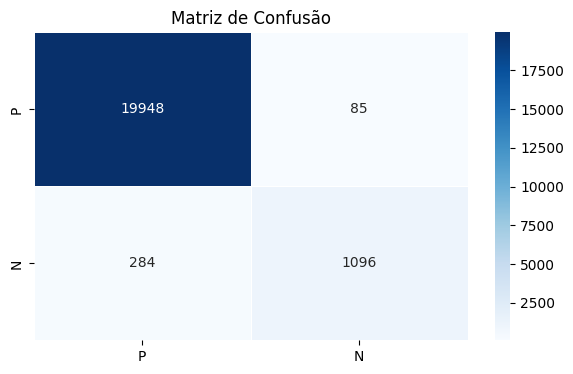

In [17]:
# Calcular a matriz de confusão
nb_conf = metrics.confusion_matrix(y_test, y_test_predict)

# Criar um DataFrame a partir da matriz de confusão
conf_df = pd.DataFrame(nb_conf, index=['P', 'N'], columns=['P', 'N'])

# Plotar a matriz de confusão
plt.figure(figsize=(7, 4))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.title('Matriz de Confusão')
plt.show()

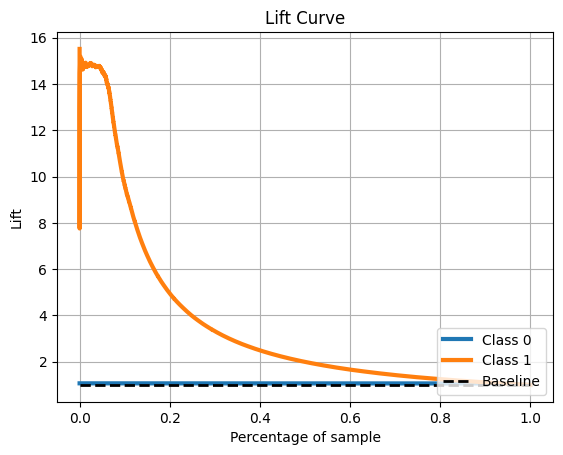

In [ ]:
#Curva ROC
#skplt.metrics.plot_roc(y_test,y_test_proba)
#plt.show()

#KS statistic
#skplt.metrics.plot_ks_statistic(y_test,y_test_proba)
#plt.show()

#Precision Recall
#skplt.metrics.plot_precision_recall(y_test, y_test_proba)
#plt.show()

#Lift curve
#skplt.metrics.plot_lift_curve(y_test,y_test_proba)
#plt.show()